<b><pre>IMPORTING REQUIRED PACKAGES AND FILES</pre></b>

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# importing mlLearner custom file
from mlLearner import my_machine_learner as ml

# importing packages to split the data
from sklearn.model_selection import train_test_split

# importing packages to make pipline
from sklearn.pipeline import make_pipeline

# importing preprocessing libraries
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

# Importing different machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# importing package to check the cross validation score
from sklearn.model_selection import cross_val_score

# importing the resampling package
from sklearn.utils import resample

<b><pre>IMPORTING DATA</pre></b>

In [2]:
# importing the dataset
data=pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
# looking at the first five rows of the dataset
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<b><pre>KNOWING DATA</pre></b>

In [4]:
# find the shape of your data 
data.shape

(5110, 12)

In [5]:
# get the names of the rows involed
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
# get info on the datatypes of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
# information regarding categorical columns of the data
data.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


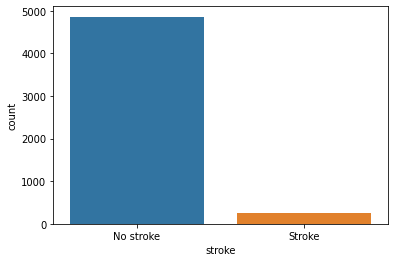

In [8]:
# looking at the frequency of various categories of output data
g = sns.countplot(x = data['stroke'])
g.set_xticklabels(['No stroke','Stroke'])
plt.show()

<pre>As we can see from the above graph, we have pretty bad balanced data. But we shall, anyways, go ahead and build our model with this unbalanced data and then check the output. And later, try to balance the data using oversampling technique and check the modified output.

<b><pre>DATA CLEANINNG</pre></b>

In [9]:
# statistical information of the numerical columns 
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [10]:
# removing unrealistic data
data_new = data.drop(data[(data['work_type']=='children') & (data['age']<= (0.1))].index)

In [11]:
# checking Nan values
data_new.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
# removing Nan values 
data_new = data_new.dropna()

In [13]:
# checking data shape after removal of unnecesaary data
data_new.shape

(4907, 12)

<b><pre>DATA PREPROCESSING AND MODEL BUILDING</pre></b>

In [14]:
# separating input and output data
X = data_new.drop(data_new.columns[[0, -1, 5]], axis = 1)
X = X.reset_index()
y = data_new['stroke']

In [15]:
# encoding categorical data
en_scale = make_column_transformer((ce.OneHotEncoder(handle_unknown='ignore'), ['gender', 'Residence_type', 'work_type']),
                                    (ce.BinaryEncoder(), ['smoking_status']), 
                                    remainder ='passthrough')

In [16]:
# scaling
SS = StandardScaler()
MM = MinMaxScaler()

scale = [SS, MM]

In [17]:
# model
RFC = RandomForestClassifier(criterion= 'gini')
DTC = DecisionTreeClassifier(criterion= 'gini', random_state=1)

model = [RFC, DTC]

In [18]:
# spliting training and test data
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=0.3)

In [19]:
# checking result using different model
for i in model:
    for j in scale:
        my_model = ml(i,train_X, test_X, train_y, test_y, en_scale, j)
        my_learner = my_model.my_model_selection()
        print(my_model.confusion_matrix(my_learner))
        print(i)
        print(j)

[[1415    0]
 [   1   57]]
RandomForestClassifier()
StandardScaler()
[[1415    0]
 [   1   57]]
RandomForestClassifier()
MinMaxScaler()
[[1415    0]
 [   1   57]]
DecisionTreeClassifier(random_state=1)
StandardScaler()
[[1415    0]
 [   1   57]]
DecisionTreeClassifier(random_state=1)
MinMaxScaler()


<b><pre>BALANCING DATA</pre></b>

In [20]:
# spliting data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# returning to one dataframe
training_set = X_train.merge(y_train, on = X_train.index)

# separating classes
stroke = training_set[training_set.stroke == 1]
not_stroke = training_set[training_set.stroke == 0]

In [21]:
# oversampling the majority
oversample = resample(stroke, 
                       replace=True, 
                       n_samples=len(not_stroke), #set the number of samples to equal the number of the minority class
                       random_state=42)

# returning to new training set
oversample_train = not_stroke.append(oversample)
oversample_train = oversample_train.drop('key_0', axis=1)

In [22]:
# separating undersampled data into X and y sets
oversample_x_train = oversample_train.drop('stroke', axis=1)
oversample_y_train = oversample_train.stroke
oversample_y_train = pd.DataFrame(oversample_y_train.values.reshape(len(oversample_y_train),1), columns =['stroke'])

In [23]:
# checking result with different models
for i in model:
    for j in scale:
        my_model = ml(i,train_X, test_X, train_y, test_y, en_scale, j)
        my_learner = my_model.my_model_selection()
        print(my_model.confusion_matrix(my_learner))
        print(i)
        print(j)

[[1415    0]
 [   1   57]]
RandomForestClassifier()
StandardScaler()
[[1415    0]
 [   1   57]]
RandomForestClassifier()
MinMaxScaler()
[[1415    0]
 [   1   57]]
DecisionTreeClassifier(random_state=1)
StandardScaler()
[[1415    0]
 [   1   57]]
DecisionTreeClassifier(random_state=1)
MinMaxScaler()
